# Neural Networks

In [2]:
%load_ext IPython.extensions.autoreload
%autoreload 2

In [3]:
import sys,os
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import numpy as np
from src.data_reader import DataSource, read_vertices_VTK, num_vertices_VTK
from src.descriptors.dscs_driver import compute_descriptors

from src.utils import get_free_id, write_jsonl, clear_jsonl

!pip install numpy==1.23.0

In [5]:
from ripser import ripser
from persim import plot_diagrams

In [6]:
from gudhi import RipsComplex, AlphaComplex, plot_persistence_diagram
from gudhi.representations import ProminentPoints
from gudhi.representations import PersistenceImage

In [7]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.mixture import GaussianMixture as GMM
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_recall_curve

import joblib

In [8]:
import csv

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchinfo import summary as torch_summary

from IPython.display import display, clear_output

from src.learning.nn import SimpleNN, train, predict, Autoencoder

### Reload descriptors

In [72]:
# load descriptors

Model='quantiles'
Model='AlphaProminent'

# data base path
data_base = './data/data/'

save_descs_path = os.path.join(data_base,'saved_descriptors/train_set/')

data = np.load(os.path.join(save_descs_path,Model+'Data.npy'))
labels = np.load(os.path.join(save_descs_path,Model+'Labels.npy'))

data = np.load('ThisData.npy')

print(data.shape, labels.shape)

(9244, 96) (9244,)


## Normalization

In [38]:
SSc = StandardScaler()
data = SSc.fit_transform(data)
data.shape

(9244, 75)

# Cross-Validation

In [356]:
StrShSp = StratifiedShuffleSplit(n_splits=15, train_size=0.8, random_state=42)

# get indices of split
train_idx, val_idx = next(StrShSp.split(data, labels))

train_data = data[train_idx,:]
train_labels = labels[train_idx]

val_data = data[val_idx]
val_labels = labels[val_idx]

# log file for run
run_log = './runs/trainings/runs.jsonl'
# get a new run id
run_id = get_free_id(run_log)


In [357]:
train_idx.shape

(77274,)

<BarContainer object of 100 artists>

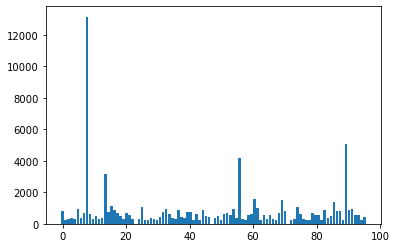

In [358]:
counts, bins = np.histogram(train_labels, bins=100)
plt.bar(bins[:-1],counts)

<BarContainer object of 100 artists>

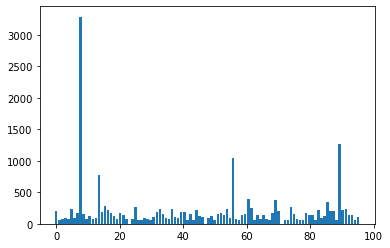

In [359]:
counts, bins = np.histogram(val_labels, bins=100)
plt.bar(bins[:-1],counts)

In [360]:
_, counts = np.unique(labels,return_counts=True)
np.sort(counts)

array([  314,   314,   314,   314,   314,   314,   314,   314,   314,
         314,   321,   321,   321,   321,   335,   335,   342,   349,
         356,   363,   370,   370,   370,   370,   370,   398,   398,
         405,   419,   419,   426,   426,   433,   447,   454,   461,
         475,   482,   489,   531,   538,   545,   559,   594,   601,
         608,   643,   643,   664,   671,   678,   678,   699,   699,
         706,   706,   727,   762,   783,   790,   797,   811,   811,
         818,   825,   832,   832,   846,   860,   923,   951,   965,
         965,   979,  1007,  1014,  1021,  1063,  1105,  1112,  1126,
        1133,  1182,  1189,  1196,  1203,  1245,  1301,  1350,  1378,
        1721,  1861,  1980,  3912,  5232,  6304, 16432])

In [361]:
np.unique(val_labels).shape

(97,)

# Classifier

### NN

In [362]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device = ',device)

X_train = torch.tensor(train_data, dtype=torch.float32)
y_train = torch.tensor(train_labels, dtype=torch.long)

X_val = torch.tensor(val_data, dtype=torch.float32)
y_val = torch.tensor(val_labels, dtype=torch.long)

#WX_val = torch.tensor(data, dtype=torch.float32)
#Wy_val = torch.tensor(labels, dtype=torch.long)



# data loader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128)
#whole_data = DataLoader(TensorDataset(WX_val, Wy_val), batch_size=128)

Device =  cuda


In [363]:
# Model, Loss, and Optimizer

m = train_data.shape[1]
c = np.unique(labels).shape[0]

# Model save path
trained_model_path = './trained_models/nn/best_weights.pth'

model = SimpleNN(m, c)

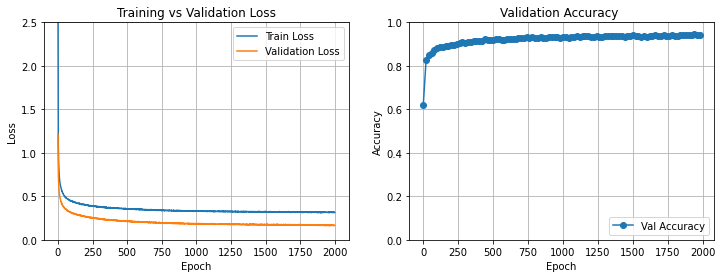

Epoch 2000, Validation Loss: 0.1653


In [364]:
summary = torch_summary(model,None)

try: 
    pass
    #model.load_state_dict(torch.load(trained_model_path))
except:
    pass
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=4e-4, weight_decay=1e-4)  # Adam optimizer

epochs = 2000
# Early Stopping Parameters
patience = int(epochs/10)  # Stop if no improvement for 'patience' epochs

params = {'id':run_id , 'model':str(type(model).__name__) , 'epochs':epochs , 'patience':patience , \
          'optimizer':str(type(optimizer).__name__) , 'loss':str(type(criterion).__name__) , \
         'model_summary':[str(summary)]}


train(epochs, model, criterion, optimizer, train_loader, val_loader, trained_model_path, patience)

#### Good values!

we get a good training with dropout 25%, input to 50, 50 to 50, 50 to output
with learning rate 5 10-5 and decay 1e-4

In [23]:
model.eval()

        
val_loss = 0.0
with torch.no_grad():
    for X_batch, y_batch in val_loader:
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        val_loss += loss.item()


val_loss /= len(val_loader)
val_loss

0.24958899822728386

NameError: name 'device' is not defined

In [208]:
model = SimpleNN(m, c)
model.load_state_dict(torch.load(trained_model_path))
model.to(device)
model.eval()

pred_labels = predict(model, val_loader, device)

In [367]:
model.to(device)
model.eval()

pred_labels = predict(model, val_loader, device)
#pred_labels = predict(model, whole_data, device)

# Scoring

In [368]:
acc = accuracy_score(val_labels, pred_labels)
#acc = accuracy_score(labels, pred_labels)

#params.update( {'accuracy':acc} )
#write_jsonl(run_log, params)
print(acc)

0.9420777472954087


In [369]:
print(classification_report(val_labels, pred_labels, zero_division=0.0))
#print(classification_report(labels, pred_labels, zero_division=0.0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00        64
           2       0.98      1.00      0.99        84
           3       0.99      1.00      0.99        89
           4       0.91      1.00      0.95        81
           5       1.00      0.99      1.00       238
           6       1.00      1.00      1.00        95
           7       1.00      0.98      0.99       165
           8       1.00      1.00      1.00      3286
           9       0.90      1.00      0.95       152
          10       1.00      1.00      1.00        80
          11       1.00      1.00      1.00       120
          12       1.00      1.00      1.00        74
          13       1.00      1.00      1.00        91
          14       0.75      0.84      0.79       782
          15       0.97      1.00      0.99       185
          16       1.00      0.97      0.98       276
          17       1.00    

In [370]:
np.unique(pred_labels).shape

(97,)

In [371]:
np.unique(val_labels).shape

(97,)

In [372]:
hist, bins = np.histogram(pred_labels, bins=np.arange(0,97), density=True)
histTruth, _ = np.histogram(labels, bins=np.arange(0,97), density=True)

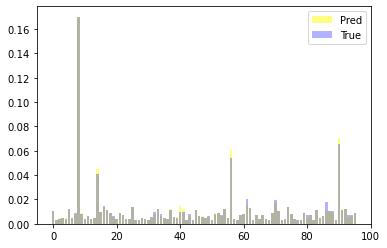

In [373]:
plt.bar(bins[:-1],hist, alpha=0.5, color='yellow', label='Pred')
plt.bar(bins[:-1],histTruth, alpha=0.3, color='blue', label='True')
plt.legend()

In [374]:
cm = confusion_matrix(val_labels, pred_labels, normalize='pred')

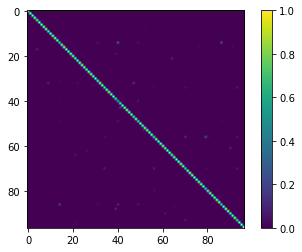

In [375]:
plt.imshow(cm)
plt.colorbar()

In [73]:
cm[32, 47]

0.17391304347826086

### Make model persistent

In [87]:
absname, ext = os.path.splitext(trained_model_path)
name = absname + str(run_id) + ext
modelname = absname + str(run_id) + 'Model' + ext
torch.save(model.state_dict(), name)
torch.save(model, modelname)


In [91]:
mod = torch.load(modelname, weights_only=False)

# Autoencoder

In [49]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('Device = ',device)

X_train = torch.tensor(train_data, dtype=torch.float32)
#y_train = torch.tensor(train_labels, dtype=torch.long)

X_val = torch.tensor(val_data, dtype=torch.float32)
#y_val = torch.tensor(val_labels, dtype=torch.long)

# data loader
train_loader = DataLoader(TensorDataset(X_train, X_train), batch_size=50, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, X_val), batch_size=50)

Device =  cuda


In [183]:
# Model, Loss, and Optimizer

p = train_data.shape[1]
p = 75

# Model save path
trained_model_path = './trained_models/nn/Autoencoder_best_weights.pth'

model = Autoencoder(p, noise = 0.0)

summary = torch_summary(model,None)

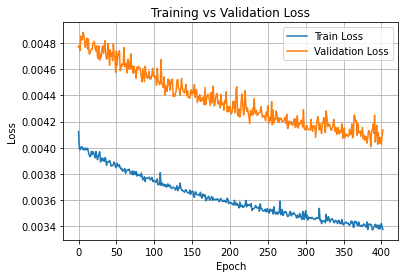

KeyboardInterrupt: 

In [ ]:
try: 
    pass
    model.load_state_dict(torch.load(trained_model_path))
except:
    pass
criterion = nn.MSELoss()  # Cross-entropy loss
optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Adam optimizer

epochs = 2000
# Early Stopping Parameters
patience = epochs  # Stop if no improvement for 'patience' epochs

params = {'id':run_id , 'model':str(type(model).__name__) , 'epochs':epochs , 'patience':patience , \
          'optimizer':str(type(optimizer).__name__) , 'loss':str(type(criterion).__name__) , \
         'model_summary':[str(summary)]}


train(epochs, model, criterion, optimizer, train_loader, val_loader, trained_model_path, patience)

In [190]:
modelAE = Autoencoder(75, noise = 0.0)

In [191]:
modelAE = joblib.load( './trained_models/nn/Autoencoder_best_weights12.pkl' )

### Write model

In [57]:
model_path_filename, extension = os.path.splitext(trained_model_path)
joblib.dump(model , model_path_filename + str(run_id) +'.pkl');

### Score

In [63]:
losses = []

for i in range(val_data.shape[0]):
    X = val_data[ i , :]
    X = torch.tensor(X, dtype=torch.float32)
    output = model.forward( X )
    loss = criterion( output , X ).detach().numpy()

    losses.append(loss)

print(np.mean( np.array(losses, dtype=float) ))



0.0033910545772518268


In [195]:
data = np.load('./data/data/saved_descriptors/train_set/AlphaProminent.npy')

## Use encoder

In [196]:
encoded_data = np.zeros( ( data.shape[0] , 15 ) )

for i in range(data.shape[0]):

    X = data[ i , :]
    X = torch.tensor(X, dtype=torch.float32)
    
    compressed = model.encode(X).detach().numpy()
    encoded_data[ i , : ] = compressed
    

In [197]:
encoded_data.shape

(9244, 15)

### Save data

In [198]:
np.save( './data/data/saved_descriptors/train_set/Take2EncodedAlphaProminent.npy', encoded_data)

# Augmented Data

In [437]:
dataCleanAlpha_aug = np.load('./data/data/saved_descriptors/train_set/CleanAlphaProminent_aug.npy')
dataS_aug = np.load('./data/sectors/saved_descriptors/train_set/AugmentedData.npy')
labels = np.load('./data/sectors/saved_descriptors/train_set/AugmentedLabels.npy')

In [204]:
data = np.concatenate( [dataS_aug , dataCleanAlpha_aug] , axis = 1 )

### Augmented Data on Test Set

In [28]:
TestdataCleanAlpha_aug = np.load('./data/data/saved_descriptors/test_set/CleanAlphaProminent_aug.npy')
TestdataS_aug = np.load('./data/sectors/saved_descriptors/test_set/TestAugmentedData.npy')

In [29]:
TestData = np.concatenate( [TestdataS_aug , TestdataCleanAlpha_aug] , axis = 1 )

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
m = TestData.shape[1]
c = 97
trained_model_path = './trained_models/nn/remote_best_weights.pth'
#trained_model_path = './trained_models/nn/remote_best_weights111.pth'
model = SimpleNN(m, c)
model.load_state_dict(torch.load(trained_model_path))
model.to(device)
model.eval()

SimpleNN(
  (dr): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=135, out_features=111, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=111, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=97, bias=True)
  (fc4): Linear(in_features=97, out_features=97, bias=True)
)

In [31]:
X_predict = torch.tensor(TestData, dtype=torch.float32).to(device)

In [32]:
output = model( X_predict )

In [33]:
y_pred = torch.argmax(output, dim=1)
y_pred = y_pred.cpu().numpy()

In [34]:
np.unique(y_pred).shape

(85,)

### Accuracy

In [17]:
pred_labels = predict(model,val_loader,device)

NameError: name 'val_loader' is not defined

In [408]:
acc = accuracy_score(val_labels, pred_labels)
print(acc)

0.9420777472954087


In [409]:
print(classification_report(val_labels, pred_labels, zero_division=0.0))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       1.00      1.00      1.00        64
           2       0.98      1.00      0.99        84
           3       0.99      1.00      0.99        89
           4       0.91      1.00      0.95        81
           5       1.00      0.99      1.00       238
           6       1.00      1.00      1.00        95
           7       1.00      0.98      0.99       165
           8       1.00      1.00      1.00      3286
           9       0.90      1.00      0.95       152
          10       1.00      1.00      1.00        80
          11       1.00      1.00      1.00       120
          12       1.00      1.00      1.00        74
          13       1.00      1.00      1.00        91
          14       0.75      0.84      0.79       782
          15       0.97      1.00      0.99       185
          16       1.00      0.97      0.98       276
          17       1.00    

In [56]:
cm = confusion_matrix(val_labels, pred_labels, normalize='pred')

Text(0, 0.5, 'Class')

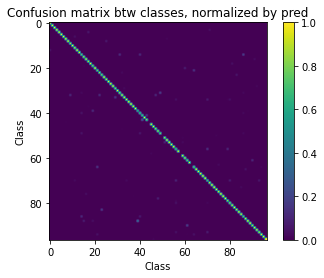

In [61]:
plt.imshow(cm)
plt.colorbar()
plt.title( 'Confusion matrix btw classes, normalized by pred' )
plt.xlabel('Class')
plt.ylabel('Class')

### Performance on test set

In [35]:
bl_pred = y_pred.reshape(-1,8)

In [36]:
unique_counts = np.array([ len( np.unique(block ) ) for block in bl_pred ]) 

Text(0.5, 0, 'Test protein Id')

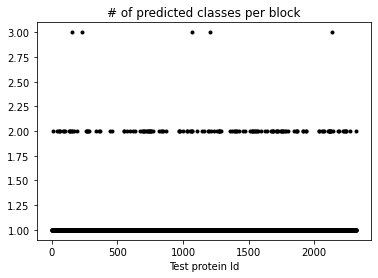

In [37]:
plt.plot(unique_counts, '.k')
plt.title('# of predicted classes per block')
plt.xlabel('Test protein Id')

In [38]:
np.where( unique_counts == 3 )[0].shape

(5,)

### Distributions

In [39]:
uni_counts = [np.unique(block, return_counts=True) for block in bl_pred]

In [40]:
uni_counts

[(array([39]), array([8])),
 (array([10]), array([8])),
 (array([8]), array([8])),
 (array([61]), array([8])),
 (array([14]), array([8])),
 (array([56]), array([8])),
 (array([14]), array([8])),
 (array([8]), array([8])),
 (array([81]), array([8])),
 (array([90]), array([8])),
 (array([91]), array([8])),
 (array([8]), array([8])),
 (array([56, 79]), array([7, 1])),
 (array([8]), array([8])),
 (array([19]), array([8])),
 (array([90]), array([8])),
 (array([90]), array([8])),
 (array([40]), array([8])),
 (array([70]), array([8])),
 (array([61]), array([8])),
 (array([70]), array([8])),
 (array([56]), array([8])),
 (array([45]), array([8])),
 (array([8]), array([8])),
 (array([56]), array([8])),
 (array([14]), array([8])),
 (array([25]), array([8])),
 (array([16]), array([8])),
 (array([37]), array([8])),
 (array([8]), array([8])),
 (array([8]), array([8])),
 (array([14]), array([8])),
 (array([87]), array([8])),
 (array([14]), array([8])),
 (array([92]), array([8])),
 (array([56]), array

In [41]:
forecast_matrix = np.zeros( (bl_pred.shape[0] , 97) )

In [42]:
for i,protein in enumerate(uni_counts):
    classes = protein[0]
    counts = protein[1]

    for j , cl in enumerate(classes):

        forecast_matrix[ i , cl  ] = counts[j]


In [43]:
sorted_classes = []

for protein in uni_counts:
    classes = protein[0]
    counts = protein[1]

    order = np.argsort(counts)[::-1]

    classes = classes[order]
    counts = counts[order]

    sorted_classes.append( [ classes, counts ] )
    

In [44]:
sorted_classes = [ [x[0] , [y/8 for y in x[1]]] for x in sorted_classes ]

In [45]:
sorted_classes = [ [ x[0].tolist(), x[1]] for x in sorted_classes]

In [46]:
sorted_classes

[[[39], [1.0]],
 [[10], [1.0]],
 [[8], [1.0]],
 [[61], [1.0]],
 [[14], [1.0]],
 [[56], [1.0]],
 [[14], [1.0]],
 [[8], [1.0]],
 [[81], [1.0]],
 [[90], [1.0]],
 [[91], [1.0]],
 [[8], [1.0]],
 [[56, 79], [0.875, 0.125]],
 [[8], [1.0]],
 [[19], [1.0]],
 [[90], [1.0]],
 [[90], [1.0]],
 [[40], [1.0]],
 [[70], [1.0]],
 [[61], [1.0]],
 [[70], [1.0]],
 [[56], [1.0]],
 [[45], [1.0]],
 [[8], [1.0]],
 [[56], [1.0]],
 [[14], [1.0]],
 [[25], [1.0]],
 [[16], [1.0]],
 [[37], [1.0]],
 [[8], [1.0]],
 [[8], [1.0]],
 [[14], [1.0]],
 [[87], [1.0]],
 [[14], [1.0]],
 [[92], [1.0]],
 [[56], [1.0]],
 [[83], [1.0]],
 [[14], [1.0]],
 [[90], [1.0]],
 [[8], [1.0]],
 [[8], [1.0]],
 [[15], [1.0]],
 [[8], [1.0]],
 [[56, 70], [0.875, 0.125]],
 [[33], [1.0]],
 [[62], [1.0]],
 [[7], [1.0]],
 [[79], [1.0]],
 [[21], [1.0]],
 [[8], [1.0]],
 [[84], [1.0]],
 [[22], [1.0]],
 [[14], [1.0]],
 [[22], [1.0]],
 [[9], [1.0]],
 [[90, 61], [0.75, 0.25]],
 [[14], [1.0]],
 [[49, 14], [0.625, 0.375]],
 [[55], [1.0]],
 [[56], [1.0]],
 [[

## Majority voting + class frequencies

Sometimes there is no strict majority, in that case we break ties by which class has the highest frequency

In [47]:
majority_voting = []
weak_majorities = 0

In [48]:
_ , label_counts = np.unique(labels, return_counts=True)

NameError: name 'labels' is not defined

In [49]:
for classes, counts in sorted_classes:

    max_freq = np.max(counts)

    tied_classes = [cls for cls, cts in zip(classes, counts) if cts == max_freq]

    if len(tied_classes)==1:
        majority_voting.append(tied_classes[0])

    else:
        top_class = max( tied_classes, key = lambda n : label_counts[n] )
        majority_voting.append(top_class)
        weak_majorities += 1


NameError: name 'label_counts' is not defined

In [50]:
weak_majorities

0

### Plot histogram

In [51]:
hist, bins = np.histogram(majority_voting, bins=np.arange(0,97), density=True)
histTruth, _ = np.histogram(labels, bins=np.arange(0,97), density=True)

NameError: name 'labels' is not defined

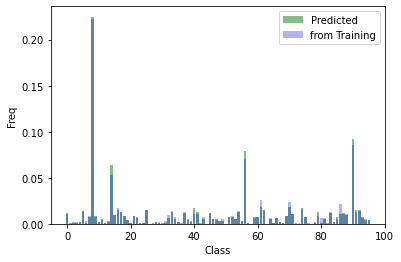

In [439]:
plt.bar(bins[:-1],hist, alpha=0.5, color='green', label='Predicted')
plt.bar(bins[:-1],histTruth, alpha=0.3, color='blue', label='from Training')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.legend()

In [52]:
import pandas as pd

In [54]:
result_labels = np.array(majority_voting)

In [55]:
result = np.column_stack( [np.arange(result_labels.shape[0]) , result_labels] )

In [56]:
result = pd.DataFrame(result)

In [432]:
result.to_csv('./data/results/classification135/Classification135Balanced.csv', header=['Protein','Class'], index=None)

In [433]:
sorted_classes_csv = pd.DataFrame(sorted_classes)

In [434]:
sorted_classes_csv.insert(0, 'Protein', range(len(sorted_classes_csv)))

In [435]:
sorted_classes_csv.to_csv( './data/results/classification135/ClassesProbabilitiesBalanced.csv', header=['Protein','Classes','Probabilities'], index=None )

In [436]:
sorted_classes_csv

,Protein,0,1
0,0,[39],[1.0]
1,1,[10],[1.0]
2,2,[8],[1.0]
3,3,[61],[1.0]
4,4,[14],[1.0]
...,...,...,...
2316,2316,[70],[1.0]
2317,2317,[92],[1.0]
2318,2318,[51],[1.0]
2319,2319,[90],[1.0]


### Dataset Balancing

In [337]:
_ , class_counts = np.unique(labels[::8], return_counts=True)
class_counts

array([ 101,    3,   17,   21,   15,  127,   25,   75, 2054,   66,   14,
         43,   10,   22,  489,   89,  154,  116,   76,   42,    7,   74,
         58,   10,   10,  143,    2,    3,   18,   14,    3,   33,   93,
        126,   73,   23,    8,  119,   34,   19,   95,   95,    2,   70,
          2,  109,   44,   37,   27,   49,    2,   71,   76,   53,  128,
         26,  654,    9,    2,   54,   73,  240,  135,    2,   57,   10,
         54,   17,    5,   80,  223,  102,    2,    6,  150,   69,   10,
          2,    5,   78,   57,   58,    2,  115,   18,   49,  203,  103,
         97,    3,  788,  118,  129,   61,   52,    2,   35])

In [323]:
small_classes = np.where(class_counts <= 10)[0]

In [324]:
small_classes

array([ 1, 12, 20, 23, 24, 26, 27, 30, 36, 42, 44, 50, 57, 58, 63, 65, 68,
       72, 73, 76, 77, 78, 82, 89, 95])

In [325]:
def balance( n ):
    if n <= 3:
        return 30

    elif n <=8:
        return 12

    elif n<=20:
        return 4

    else:
        return 2
        

In [326]:
class_counts[1]

3

In [338]:
X_new = []
y_new = []
min_size = 300

In [339]:
for i, count in enumerate(class_counts):

    if count <= min_size:

        cls_ind = np.where(labels == i)[0]
    
        to_add = min_size - count
    
        print('Class', i, 'with', count, 'elements')
    
        print('Adding ', to_add, 'times')

        reps = np.random.choice(cls_ind, size=to_add, replace=True)

    
        X_new.append(data[reps])
        y_new.append(labels[reps])

Class 0 with 101 elements
Adding  199 times
Class 1 with 3 elements
Adding  297 times
Class 2 with 17 elements
Adding  283 times
Class 3 with 21 elements
Adding  279 times
Class 4 with 15 elements
Adding  285 times
Class 5 with 127 elements
Adding  173 times
Class 6 with 25 elements
Adding  275 times
Class 7 with 75 elements
Adding  225 times
Class 9 with 66 elements
Adding  234 times
Class 10 with 14 elements
Adding  286 times
Class 11 with 43 elements
Adding  257 times
Class 12 with 10 elements
Adding  290 times
Class 13 with 22 elements
Adding  278 times
Class 15 with 89 elements
Adding  211 times
Class 16 with 154 elements
Adding  146 times
Class 17 with 116 elements
Adding  184 times
Class 18 with 76 elements
Adding  224 times
Class 19 with 42 elements
Adding  258 times
Class 20 with 7 elements
Adding  293 times
Class 21 with 74 elements
Adding  226 times
Class 22 with 58 elements
Adding  242 times
Class 23 with 10 elements
Adding  290 times
Class 24 with 10 elements
Adding  290 t

In [340]:
X_new = np.concatenate( X_new, axis = 0 )

In [341]:
y_new = np.concatenate( y_new, axis = 0 )

In [342]:
balanced_data = np.concatenate( [data, X_new] , axis = 0 )

In [343]:
balanced_labels = np.concatenate( [labels, y_new] , axis = 0 )

In [344]:
balanced_data.shape

(96593, 135)

In [345]:
balanced_labels.shape

(96593,)

### New histogram

In [352]:
hist, bins = np.histogram(balanced_labels, bins=np.arange(0,97), density=True)
histTruth, _ = np.histogram(labels, bins=np.arange(0,97), density=True)

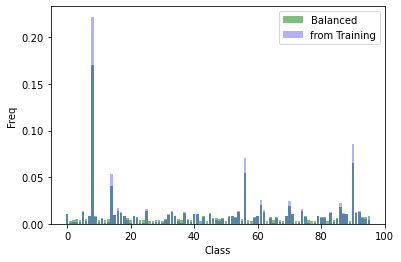

In [353]:
plt.bar(bins[:-1],hist, alpha=0.5, color='green', label='Balanced')
plt.bar(bins[:-1],histTruth, alpha=0.3, color='blue', label='from Training')
plt.xlabel('Class')
plt.ylabel('Freq')
plt.legend()

<BarContainer object of 96 artists>

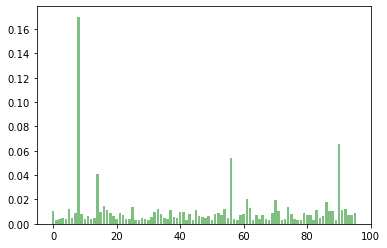

In [354]:
plt.bar(bins[:-1],hist, alpha=0.5, color='green', label='Balanced', )

In [355]:
data = balanced_data
labels = balanced_labels

In [64]:
result.to_numpy()[:,1]

array([39, 10,  8, 61, 14, 56, 14,  8, 81, 90, 91,  8, 56,  8, 19, 90, 90,
       40, 70, 61, 70, 56, 45,  8, 56, 14, 25, 16, 37,  8,  8, 14, 87, 14,
       92, 56, 83, 14, 90,  8,  8, 15,  8, 56, 33, 62,  7, 79, 21,  8, 84,
       22, 14, 22,  9, 90, 14, 49, 55, 56, 41, 70, 14, 90, 55, 60, 56,  7,
       90, 15,  8, 87, 14, 75, 16, 56,  8,  8, 88, 14,  8,  8, 91, 70, 96,
        8, 15,  8,  8, 90, 90,  8,  8, 90,  8])

In [69]:
y_pred

array([39, 39, 39, ..., 14, 14, 14])

In [74]:
ground_truth = pd.read_csv('test_set_ground_truth.csv').to_numpy()[:,1]

array([88, 10,  8, ...,  8, 75, 51])

In [76]:
clean_y_pred = np.array([ y_pred[8*i] for i in range(ground_truth.shape[0])])

In [83]:
n_correct = np.where( clean_y_pred == ground_truth )[0].shape[0]

In [86]:
n_correct / ground_truth.shape[0]

0.07496768634209393

In [91]:
perm = pd.read_csv('CombinedMethod/Permutation.csv').to_numpy()[:,0]

In [93]:
n_correct = np.where( clean_y_pred == ground_truth[perm] )[0].shape[0]

/tmp/ipykernel_79354/437835453.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  n_correct = np.where( clean_y_pred == ground_truth[perm] )[0].shape[0]


In [95]:
perm_clean_y_pred = clean_y_pred[perm]

In [96]:
n_correct = np.where( perm_clean_y_pred == ground_truth )[0].shape[0]

/tmp/ipykernel_79354/121178260.py:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  n_correct = np.where( perm_clean_y_pred == ground_truth )[0].shape[0]


In [97]:
perm_clean_y_pred.shape

(2320,)

In [99]:
ground_truth.shape

(2321,)